# Initial Setups

## (Google Colab use only)

In [64]:
# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/ATSC'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ATSC
 apex-master.zip
 baseline
 bert_base_cache
 checkpoint-1210520
 checkpoint-553363.zip
 dataset_cache
'dataset_cache (1)'
 dataset_files
 dataset_scripts
 GPT2
 gpt2_amazon
 gpt2_cache
 MLM
 NLI
 nli-checkpoint-epoch2
 nli_files.txt
 NLIResults
 prompt_lr_atsc_single_prompt_the_aspect_gpt-2_yelp_restaurants
 requirements.txt
 semeval_data_files
 smart_mlm_yelp_500k_15percent.ipynb
 utils


## Experiment parameters

In [65]:
import torch
class SinglePromptLogitSentimentClassificationHead(torch.nn.Module):
    def __init__(self, lm, num_class, pseudo_label_words, target_token_id=-1):
        super(SinglePromptLogitSentimentClassificationHead, self).__init__()

        self.num_class = num_class
        self.pseudo_label_words = pseudo_label_words
        self.target_token_id = target_token_id

        self.lm = lm
        
        # Is self.lm BERT or GPT-2?
        if self.lm.config.architectures[0].startswith('Bert'):
            # if self.lm is BERT, then mask_token_id should be specified
            assert self.target_token_id != -1
            self.lm_type = 'bert'
        elif self.lm.config.architectures[0].startswith('GPT2'):
            self.lm_type = 'gpt2'
        else:
            raise Exception('Unsupported language model type.')
            
        print("Detected LM type:", self.lm_type)

    def forward(self, reviews_and_prompts):

        if self.lm_type == 'bert':
            # Figures out where the mask token was placed
            target_indexes = (reviews_and_prompts.data["input_ids"] == self.target_token_id)

            lm_outputs = self.lm(**reviews_and_prompts)

            outputs = lm_outputs.logits[target_indexes]
        
            outputs = outputs[:, self.pseudo_label_words]
            
        elif self.lm_type == 'gpt2':
            
            outputs = []
            
            for example in reviews_and_prompts:
                lm_outputs = self.lm(**example, return_dict=True)
                
                lm_predictions = lm_outputs.logits[0, len(example['input_ids'][0]) - 1, self.pseudo_label_words]
                
                outputs.append(lm_predictions)

            outputs = torch.stack(outputs, dim=0)

        return outputs


class MultiPromptSentimentClassificationHead(torch.nn.Module):
    def __init__(self, lm, num_class, num_prompts, target_token_id=-1):
        super(MultiPromptSentimentClassificationHead, self).__init__()

        self.num_class = num_class
        self.num_prompts = num_prompts
        self.target_token_id = target_token_id

        self.lm = lm
        
        # Is self.lm BERT or GPT-2?
        if self.lm.config.architectures[0].startswith('Bert'):
            # if self.lm is BERT, then mask_token_id should be specified
            assert self.target_token_id != -1
            self.lm_type = 'bert'
        elif self.lm.config.architectures[0].startswith('GPT2'):
            self.lm_type = 'gpt2'
        else:
            raise Exception('Unsupported language model type.')

        print("Detected LM type:", self.lm_type)

        # Linear layer
        self.linear = torch.nn.Linear(
            self.num_prompts * self.lm.config.hidden_size, self.num_class)

    def forward(self, reviews_and_prompts):

        # Extract hidden states and feed them to self.linear
        outputs = []

        lr_inputs_batch = []

        # Figures out where the mask token was placed
        if self.lm_type == 'bert':
            # For BERT, we need to find the token in each input with [MASK]
            target_indexes = torch.nonzero(
                reviews_and_prompts.data["input_ids"] == self.target_token_id)[:, 1]

            lm_outputs = self.lm(**reviews_and_prompts, output_hidden_states=True)

            real_batch_size = len(reviews_and_prompts.data["input_ids"]) // self.num_prompts

        elif self.lm_type == 'gpt2':
            lm_outputs = []
            target_indexes = []

            # For GPT-2, we need to find the spot right after the input text
            for example in reviews_and_prompts:
                target_indexes.append(len(example['input_ids'][0]) - 1)

                lm_outputs.append(self.lm(**example, output_hidden_states=True))

            real_batch_size = len(reviews_and_prompts) // self.num_prompts
                
        for i in range(real_batch_size):
            # Create an input to self.linear by
            # concatenating last hidden states for this review
            lr_input = []

            for j in range(self.num_prompts):
                if self.lm_type == 'bert':
                    lr_input.append(lm_outputs["hidden_states"][-1][i+real_batch_size*j][target_indexes[i+real_batch_size*j]])
                elif self.lm_type == 'gpt2':
                    lr_input.append(lm_outputs[i+real_batch_size*j]["hidden_states"][-1][0][target_indexes[i+real_batch_size*j]])
                    
            lr_input = torch.cat(lr_input, dim=0)

            lr_inputs_batch.append(lr_input)

        lr_inputs_batch = torch.stack(lr_inputs_batch)

        outputs = self.linear(lr_inputs_batch)

        return outputs


class NoPromptSentimentClassificationHead(torch.nn.Module):
    def __init__(self, lm, num_class):
        super(NoPromptSentimentClassificationHead, self).__init__()

        self.num_class = num_class

        self.lm = lm

        self.linear = torch.nn.Linear(
            self.lm.config.hidden_size, self.num_class)

    def forward(self, reviews_and_prompts):

        lm_outputs = self.lm(**reviews_and_prompts, output_hidden_states=True)

        # Last hidden state for [CLS] token
        last_hidden_state_cls = lm_outputs["hidden_states"][-1][:, 0, :]
        
        outputs = self.linear(last_hidden_state_cls)

        return outputs
    
class NLISentimentClassificationHead(torch.nn.Module):
    def __init__(self, nli_model, num_prompts, pos_prompt_indexes, neg_prompt_indexes):
        super(NLISentimentClassificationHead, self).__init__()
        
        self.num_prompts = num_prompts
        self.nli_model = nli_model
        
        self.pos_prompt_indexes = pos_prompt_indexes
        self.neg_prompt_indexes = neg_prompt_indexes
        
    def forward(self, reviews_and_prompts):
        
        nli_output = self.nli_model(**reviews_and_prompts)["logits"]

        outputs = torch.Tensor().to(self.nli_model.device)

        # Text Attack NLI Labels: 0-> Contradiction, 1-> Entailment, 2-> Neutral
        # Sentiment Polarity Labels: 0-> Positive, 1-> Negative, 2-> Neutral
        for i in range(len(nli_output)//self.num_prompts):
            prompts_batch = nli_output[i*self.num_prompts:(i+1)*self.num_prompts]

            pos_logit = torch.mean(prompts_batch[self.pos_prompt_indexes], dim=0)[1]

            neg_logit = torch.mean(prompts_batch[self.neg_prompt_indexes], dim=0)[1]

            neu_logit = torch.mean(prompts_batch, dim=0)[2]

            pred_logits = torch.stack([pos_logit, neg_logit, neu_logit])
            pred_logits = torch.reshape(pred_logits, (1,-1))

            outputs = torch.cat([outputs, pred_logits])

        return outputs

class NLIMinSentimentClassificationHead(torch.nn.Module):
    def __init__(self, nli_model, num_prompts, pos_prompt_indexes, neg_prompt_indexes):
        super(NLIMinSentimentClassificationHead, self).__init__()
        
        self.num_prompts = num_prompts
        self.nli_model = nli_model
        
        self.pos_prompt_indexes = pos_prompt_indexes
        self.neg_prompt_indexes = neg_prompt_indexes
        
    def forward(self, reviews_and_prompts):
        
        nli_output = self.nli_model(**reviews_and_prompts)["logits"]

        outputs = torch.Tensor().to(self.nli_model.device)

        # Text Attack NLI Labels: 0-> Contradiction, 1-> Entailment, 2-> Neutral
        # Sentiment Polarity Labels: 0-> Positive, 1-> Negative, 2-> Neutral
        for i in range(len(nli_output)//self.num_prompts):
            prompts_batch = nli_output[i*self.num_prompts:(i+1)*self.num_prompts]

            pos_logit = torch.mean(prompts_batch[self.pos_prompt_indexes], dim=0)[1]

            neg_logit = torch.mean(prompts_batch[self.neg_prompt_indexes], dim=0)[1]

            neu_logit = torch.min(prompts_batch, dim=0)[0][2]

            pred_logits = torch.stack([pos_logit, neg_logit, neu_logit])
            pred_logits = torch.reshape(pred_logits, (1,-1))

            outputs = torch.cat([outputs, pred_logits])

        return outputs


In [66]:

# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'supervised_nli_single_prompt_1_in_domain_restaurant_MNLI_base_seed_696'

# Random seed
random_seed = 696

# path to pretrained nli model folder or the string "textattack/bert-base-uncased-MNLI"
nli_model_path = "textattack/bert-base-uncased-MNLI"

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is good.",
    "The {aspect} is bad."]

#index of the prompts in the sentiment_prompts by polarity for later grouping
pos_prompt_indexes = [0]
neg_prompt_indexes = [1]

#What datasets to be used for training and testing loops
training_domain = "restaurants"
testing_domain = "restaurants"

# Training settings
training_epochs = 20
training_batch_size = 8
training_learning_rate = 2e-5
training_weight_decay = 0.01
training_warmup_steps_duration = 0.1
training_best_model_criterion = 'train_loss'

training_lm_freeze = False

validation_enabled = False
validation_dataset_proportion = 0.2
validation_batch_size = 8

testing_batch_size = 32

In [67]:
# Parameters
experiment_id = "nli_few_shot_in_domain_laptops_1024_MNLI-base_made_me_feel_696"
random_seed = 696
nli_model_path = "textattack/bert-base-uncased-MNLI"
sentiment_prompts = [
    "The {aspect} made me feel good.",
    "The {aspect} made me feel bad.",
]
pos_prompt_indexes = [0]
neg_prompt_indexes = [1]
training_domain = "laptops"
testing_batch_size = 8
testing_domain = "laptops"
training_batch_size = 8


## Package imports

In [68]:
import sys
import os
import random
import shutil
import copy
import inspect
import json
import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
NumPy version: 1.19.5
PyTorch version: 1.7.1
Transformers version: 4.3.3


## PyTorch GPU settings

In [69]:

if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 10.2
cuDNN Version: 7605
CUDA Device Name: Tesla T4
CUDA Capabilities: (7, 5)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [70]:
# Load semeval for both domains
laptop_semeval_dataset = datasets.load_dataset(
    os.path.abspath('./dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': './dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': './dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='./dataset_cache')

restaurant_semeval_dataset = datasets.load_dataset(
    os.path.abspath('./dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': './dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': './dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='./dataset_cache')

Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (./dataset_cache/sem_eval2014_task4_dataset/default-2ba098669778f075/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)
Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (./dataset_cache/sem_eval2014_task4_dataset/default-00707989ebea381d/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [71]:
dataset_dic_train = {
    "laptops": laptop_semeval_dataset['train'],
    "restaurants": restaurant_semeval_dataset['train']
}

dataset_dic_test = {
    "laptops": laptop_semeval_dataset['test'],
    "restaurants": restaurant_semeval_dataset['test']
}


In [72]:
# The dataset chosen for training and testing
train_set = dataset_dic_train[training_domain]
test_set = dataset_dic_test[testing_domain]

## Train-validation split

In [73]:
# Training set size after validation split
if validation_enabled:
    new_train_dataset_size = int(len(train_set) * (1 - validation_dataset_proportion))
    new_valid_dataset_size = len(train_set) - new_train_dataset_size
    print("Training dataset after split:", new_train_dataset_size)
    print("Validation dataset after split:", new_train_dataset_size)
else:
    new_train_dataset_size = len(train_set)
    print("Training dataset size:", new_train_dataset_size)

Training dataset size: 2313


In [74]:
train_set = train_set.shuffle(seed=random_seed)

new_train_set = train_set.select(indices=np.arange(new_train_dataset_size))

if validation_enabled:
    new_valid_set = train_set.select(
        indices=np.arange(
            new_train_dataset_size,
            new_train_dataset_size + new_valid_dataset_size))

Loading cached shuffled indices for dataset at ./dataset_cache/sem_eval2014_task4_dataset/default-2ba098669778f075/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-de8ce8ac91817d47.arrow


In [75]:
print(new_train_set[0])

{'aspect': 'loads', 'sentiment': 2, 'text': 'Once I removed all the software the laptop loads in 15-20 seconds.'}


# Supervised ATSC with Prompts + Logistic Regression Head

## Load the pretrained LM

In [76]:
# Load pretrained language model
nli_model = transformers.AutoModelForSequenceClassification.from_pretrained(nli_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI", cache_dir='../bert_base_cache')

In [77]:
# Freeze all layers in lm.
if training_lm_freeze:
    for param in nli_model.parameters():
        param.requires_grad = False

In [78]:
classifier = NLISentimentClassificationHead(
                    nli_model = nli_model,
                    num_prompts = len(sentiment_prompts),
                    pos_prompt_indexes = pos_prompt_indexes,
                    neg_prompt_indexes = neg_prompt_indexes
                    )
classifier_model = classifier.to(torch_device)

## Training settings

In [79]:
# How many training steps would we have?
approx_total_training_steps = len(new_train_set) // training_batch_size * training_epochs

print("There will be approximately %d training steps." % approx_total_training_steps)

# Let's have warmups for the first (training_warmup_steps_duration)% of steps.
training_warmup_steps = int(approx_total_training_steps * training_warmup_steps_duration)

print("Warmup steps:", training_warmup_steps)

There will be approximately 5780 training steps.
Warmup steps: 578


In [80]:
train_dataloader = torch.utils.data.DataLoader(
    new_train_set, batch_size=training_batch_size,
    shuffle=True, pin_memory=use_pin_memory)

if validation_enabled:
    validation_dataloader = torch.utils.data.DataLoader(
        new_valid_set, batch_size=validation_batch_size, pin_memory=use_pin_memory)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(
    classifier.parameters(),
    lr=training_learning_rate,
    weight_decay=training_weight_decay)

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_warmup_steps,
    num_training_steps=len(new_train_set) * training_epochs,
)

# The directory to save the best version of the head
trained_model_directory = os.path.join('..', 'trained_models', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [81]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

## Evaluation with in-domain test set

In [82]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)
# Locate the weight file.
trained_model_directory = os.path.join('NLIResults', experiment_id)

saved_weights_name = ''

for fname in os.listdir(trained_model_directory):
    if fname.startswith('epoch'):
        saved_weights_name = fname
        break

print("Loading", saved_weights_name)

Loading epoch_14.pt


In [83]:

# Load the best found head weights
with torch.no_grad():
    
    classifier_model.load_state_dict(torch.load(os.path.join(os.path.join('NLIResults', experiment_id), saved_weights_name),map_location=torch_device))

    classifier.eval()

    predictions_test = torch.Tensor().to(torch_device)

    labels_test = torch.Tensor().to(torch_device)

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for i in range(len(batch_test["text"])):
            
            for prompt in sentiment_prompts:
                reviews_repeated.append(batch_test["text"][i])
                prompts_populated.append(prompt.format(aspect="things"))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded.to(torch_device)

        nli_output = nli_model(**batch_encoded)["logits"]

        labels = batch_test["sentiment"]
        labels = labels.to(torch_device)

        optimizer.zero_grad()
        
        outputs = classifier(batch_encoded)
        
        predictions_test = torch.cat([predictions_test, outputs])
        labels_test = torch.cat([labels_test, labels])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test.cpu(), labels_test.cpu())
    
    print(test_metrics)


{'accuracy': 0.6943573667711599, 'f1': 0.6761966327049974, 'precision': 0.7084648756570425, 'recall': 0.6946836119835499}


## Results visualization

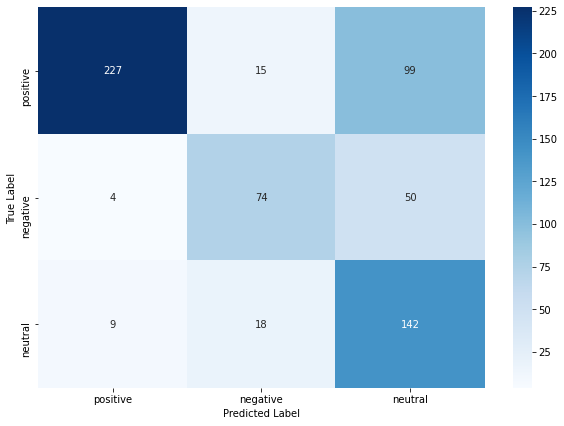

In [84]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy().argmax(-1), labels=[0,1,2])

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()